## Best FI example - further spin up

### Libraries 

In [1]:
from scipy.stats import qmc
import numpy as np
import xarray as xr
import csv
import pandas as pd
import os
import netCDF4 as nc4
import sys
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                     
import shutil                                                                                                                                                       
import tempfile 
import random

#import functions_py.modp as mp
import functions_py.fates_xarray_functions as fa

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm

dark = cm.get_cmap('Paired', 12)
colormap = dark(range(12))
colormap[10] = colormap[11]

/global/homes/j/jneedham/.conda/envs/myenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# this function takes data that has monthly values and returns a single annual value, with 
# a mean that accounts for the number of days per month
def monthly_to_annual(array):
    """ calculate annual mean from monthly data, using unequal month lengths for noleap calendar.  
    originally written by Keith Lindsay."""
    mon_day  = xr.DataArray(np.array([31.,28.,31.,30.,31.,30.,31.,31.,30.,31.,30.,31.]), dims=['month'])
    mon_wgt  = mon_day/mon_day.sum()
    return (array.rolling(time=12, center=False) # rolling
            .construct("month") # construct the array
            .isel(time=slice(11, None, 12)) # slice so that the first element is [1..12], second is [13..24]
            .dot(mon_wgt, dims=["month"]))

### Load benchmarking data

In [3]:
# regrowth curves 
dfre = pd.read_csv('/global/homes/j/jneedham/DBEN/benchmarking_data/benchmark_regrowth_curves.csv')
dfre = dfre[dfre.Biome == 'Boreal']
#print(dfre.head(20))

# stand structure data 
dfss = pd.read_csv('/global/homes/j/jneedham/DBEN/benchmarking_data/benchmark_stand_structure.csv')
dfss = dfss[dfss.site == 'FI']
#print(dfss.head(5))

# equilibrium dynamics
dfeq = pd.read_csv('/global/homes/j/jneedham/DBEN/benchmarking_data/benchmark_eq_dynamics.csv')
dfeq = dfeq[dfeq.site == 'FI']
#print(dfeq.head(5))


### Load FATES

In [4]:
fates = '/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/fi_spinup_highco2.Ef14a3cf738-F14030960.2024-07-12/run/fi_spinup_highco2.Ef14a3cf738-F14030960.2024-07-12.sofar.nc'

fates = xr.open_dataset(fates,  decode_times=False)

nyears = int(len(fates.variables['time'])/12)
n_lat = len(fates.variables['lat'])
n_lon = len(fates.variables['lon'])

tave_start = (nyears-5)
tave_stop = nyears

cohort_size_bins = fates.variables['fates_levscls']
patch_age_bins = fates.variables['fates_levage'][:]
nsizebins = len(cohort_size_bins)

time = fates.variables['time'] / 365.

print(len(time))

agb_frac = 0.6

15120


### Coexistence

Text(0, 0.5, 'Veg C (kg C m-2)')

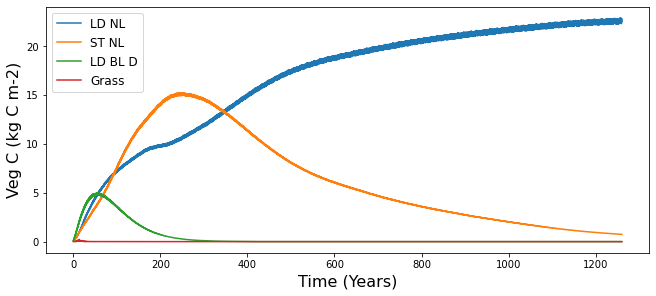

In [5]:
AGB = fates.FATES_VEGC_PF

fig1, axs = plt.subplots(nrows=1,ncols=1, figsize=(9,4), constrained_layout=True)
axs.plot(time, AGB[:,0],label = 'LD NL')  
axs.plot(time, AGB[:,1], label = 'ST NL')   
axs.plot(time, AGB[:,2],  label = 'LD BL D')   
axs.plot(time, AGB[:,3],  label = 'Grass')  
axs.legend(prop={'size':12})

axs.set_xlabel(r'Time (Years)', fontsize=16)
axs.set_ylabel(r'Veg C (kg C m-2)', fontsize=16)

        

### Equilibrium AGB

''

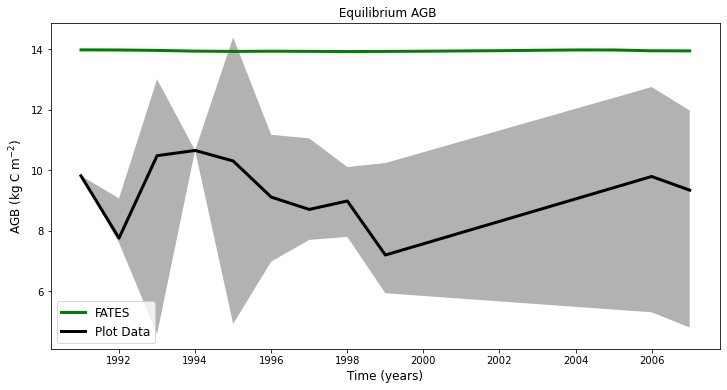

In [6]:
time_plot = list(dfeq.Year)
agb_plot = dfeq.AGB_kgCm2
agb_plot_lower = dfeq.AGB_lower_kgCm2
agb_plot_upper = dfeq.AGB_upper_kgCm2

eq_time = np.arange(time_plot[0], (time_plot[-1]+1), 1)
tstart = nyears-(len(eq_time))
tstop = nyears

AGB = monthly_to_annual(fates.FATES_VEGC_ABOVEGROUND)

fig1, ((f1ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(12,6))
f1ax0.plot(eq_time, AGB[tstart:tstop], color='green', label = 'FATES', linewidth=3)    
f1ax0.set_title(r' Equilibrium AGB', fontsize = 12)
f1ax0.set_ylabel(r'AGB (kg C m$^{-2}$)', fontsize = 12)
f1ax0.set_xlabel(r'Time (years)', fontsize = 12)    
   
f1ax0.plot(time_plot, agb_plot, color='black', label = 'Plot Data', linewidth=3)
f1ax0.fill_between(time_plot, agb_plot_lower, agb_plot_upper, alpha=0.6, facecolor='grey')

f1ax0.legend(prop={'size':12})
;

### Regrowth

''

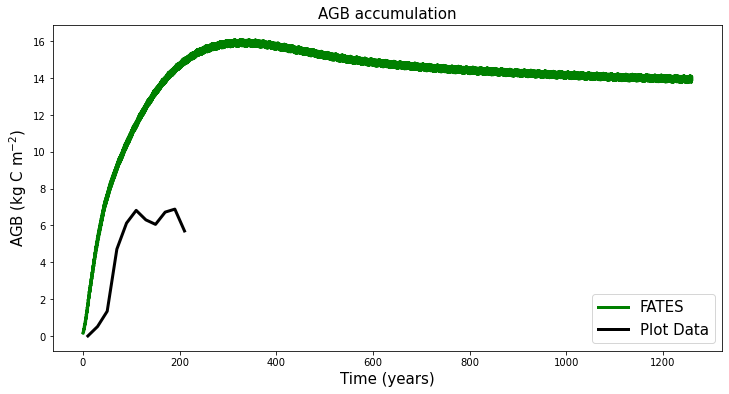

In [7]:
AGB = fates.FATES_VEGC_ABOVEGROUND


fig1, ((f1ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(12,6))
f1ax0.plot(time, AGB, color='green', label = 'FATES', linewidth=3)    

f1ax0.set_title(r'AGB accumulation', fontsize = 15)
f1ax0.set_ylabel(r'AGB (kg C m$^{-2}$)', fontsize = 15)
f1ax0.set_xlabel(r'Time (years)', fontsize = 15)    
   
time_plot = dfre.bin_num
agb_plot = dfre.AGcwood_kgCm2_med

f1ax0.plot(time_plot, agb_plot, color='black', label = 'Plot Data', linewidth =3)

f1ax0.legend(prop={'size':15})
;

### Recruitment

Text(0, 0.5, 'Recruits (No. m-2)')

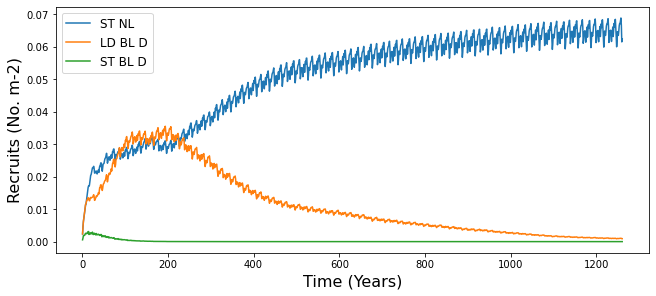

In [8]:
recr =  monthly_to_annual(fates.FATES_RECRUITMENT_PF)

time_annual  = np.linspace(1,nyears,nyears)

fig1, axs = plt.subplots(nrows=1,ncols=1, figsize=(9,4), constrained_layout=True)
axs.plot(time_annual, recr.isel(fates_levpft=0),label = 'ST NL')  
axs.plot(time_annual, recr.isel(fates_levpft=1),label = 'LD BL D')   
axs.plot(time_annual, recr.isel(fates_levpft=2),label = 'ST BL D')   
#axs.plot(time, recr.isel(fates_levpft=3),label = 'Grass')  
axs.legend(prop={'size':12})

axs.set_xlabel(r'Time (Years)', fontsize=16)
axs.set_ylabel(r'Recruits (No. m-2)', fontsize=16)


### Seed bank 

Text(0, 0.5, 'Seeds')

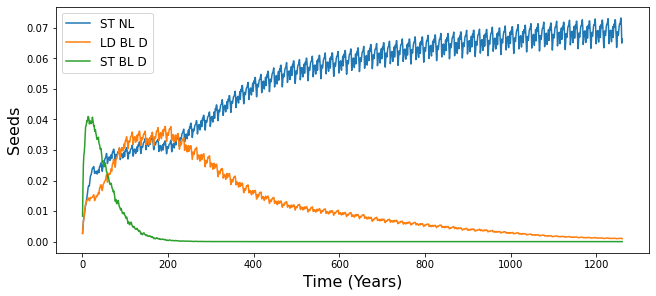

In [9]:
seedbank =  monthly_to_annual(fates.FATES_SEED_BANK_PF)

time_annual  = np.linspace(1,nyears,nyears)

fig1, axs = plt.subplots(nrows=1,ncols=1, figsize=(9,4), constrained_layout=True)
axs.plot(time_annual, seedbank.isel(fates_levpft=0),label = 'ST NL')  
axs.plot(time_annual, seedbank.isel(fates_levpft=1),label = 'LD BL D')   
axs.plot(time_annual, seedbank.isel(fates_levpft=2),label = 'ST BL D')   
#axs.plot(time, recr.isel(fates_levpft=3),label = 'Grass')  
axs.legend(prop={'size':12})

axs.set_xlabel(r'Time (Years)', fontsize=16)
axs.set_ylabel(r'Seeds', fontsize=16)

### Mortality 

In [10]:
nplant = fa.scpf_to_scls_by_pft(fates.FATES_NPLANT_SZPF, fates)


In [11]:
cstarv  = fa.scpf_to_scls_by_pft(fates.FATES_MORTALITY_CSTARV_SZPF, fates)
term = fa.scpf_to_scls_by_pft(fates.FATES_MORTALITY_TERMINATION_SZPF, fates)
background = fa.scpf_to_scls_by_pft(fates.FATES_MORTALITY_BACKGROUND_SZPF, fates)

cstarv = np.squeeze(cstarv / nplant)
term = np.squeeze(term / nplant)
background = np.squeeze(background / nplant)

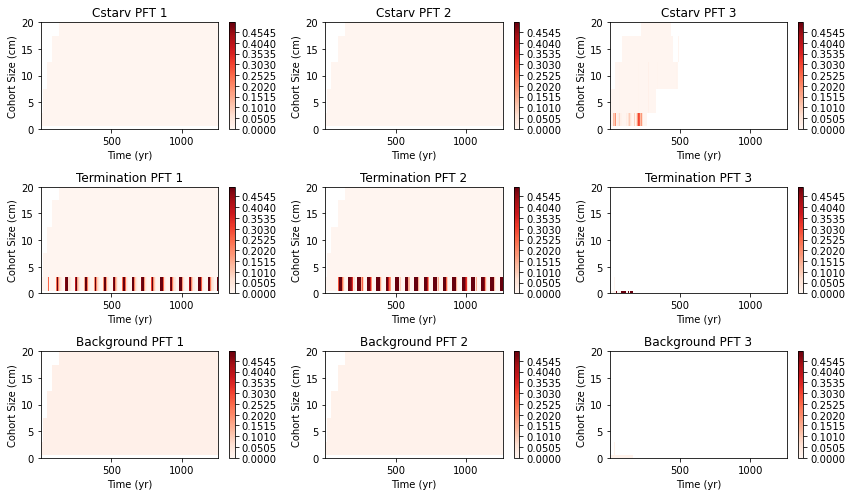

In [12]:
# set up the page
fig3, ((f3ax0,f3ax1,f3ax2), (f3ax3,f3ax4,f3ax5), (f3ax6, f3ax7,f3ax8)) = plt.subplots(nrows=3, ncols=3, figsize=(12, 7))

levels = np.linspace(0,0.5,100)
cmap = plt.get_cmap('Reds')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

im = f3ax0.pcolormesh(time, cohort_size_bins, 
                      cstarv.isel(fates_levpft=0).transpose(), 
                      cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax0)
f3ax0.set_title(r'Cstarv PFT 1')
f3ax0.set_xlabel('Time (yr)')
f3ax0.set_ylabel('Cohort Size (cm)')
f3ax0.set_ylim(0,20)

im = f3ax1.pcolormesh(time, cohort_size_bins, 
                      cstarv.isel(fates_levpft=1).transpose(),
                      cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax1)
f3ax1.set_title(r'Cstarv PFT 2')
f3ax1.set_xlabel('Time (yr)')
f3ax1.set_ylabel('Cohort Size (cm)')
f3ax1.set_ylim(0,20)

im = f3ax2.pcolormesh(time, cohort_size_bins, 
                      cstarv.isel(fates_levpft=2).transpose(), 
                      cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax2)
f3ax2.set_title(r'Cstarv PFT 3')
f3ax2.set_xlabel('Time (yr)')
f3ax2.set_ylabel('Cohort Size (cm)')
f3ax2.set_ylim(0,20)

im = f3ax3.pcolormesh(time, cohort_size_bins, 
                      term.isel(fates_levpft=0).transpose(), 
                      cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax3)
f3ax3.set_title(r'Termination PFT 1')
f3ax3.set_xlabel('Time (yr)')
f3ax3.set_ylabel('Cohort Size (cm)')
f3ax3.set_ylim(0,20)

im = f3ax4.pcolormesh(time, cohort_size_bins, 
                      term.isel(fates_levpft=1).transpose(), 
                      cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax4)
f3ax4.set_title(r'Termination PFT 2')
f3ax4.set_xlabel('Time (yr)')
f3ax4.set_ylabel('Cohort Size (cm)')
f3ax4.set_ylim(0,20)

im = f3ax5.pcolormesh(time, cohort_size_bins, 
                      term.isel(fates_levpft=3).transpose(), 
                      cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax5)
f3ax5.set_title(r'Termination PFT 3')
f3ax5.set_xlabel('Time (yr)')
f3ax5.set_ylabel('Cohort Size (cm)')
f3ax5.set_ylim(0,20)

im = f3ax6.pcolormesh(time, cohort_size_bins, 
                      background.isel(fates_levpft=0).transpose(), 
                      cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax6)
f3ax6.set_title(r'Background PFT 1')
f3ax6.set_xlabel('Time (yr)')
f3ax6.set_ylabel('Cohort Size (cm)')
f3ax6.set_ylim(0,20)

im = f3ax7.pcolormesh(time, cohort_size_bins, 
                      background.isel(fates_levpft=1).transpose(), 
                      cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax7)
f3ax7.set_title(r'Background PFT 2')
f3ax7.set_xlabel('Time (yr)')
f3ax7.set_ylabel('Cohort Size (cm)')
f3ax7.set_ylim(0,20)

im = f3ax8.pcolormesh(time, cohort_size_bins, 
                      background.isel(fates_levpft=3).transpose(), 
                      cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax8)
f3ax8.set_title(r'Background PFT 3')
f3ax8.set_xlabel('Time (yr)')
f3ax8.set_ylabel('Cohort Size (cm)')
f3ax8.set_ylim(0,20)

fig3.tight_layout()

### Size distributions

In [13]:
# dbh_classes_num are UPPER  bounds. Remove the  first size  bin
plot_sizebin = np.array(dfss.dbh_classes_num)
plot_sizebin_mids = (plot_sizebin[0:-1] + plot_sizebin[1:])/2
plot_sizebin_widths = plot_sizebin[1:] - plot_sizebin[:-1]
plot_nplant = dfss['nstem_size_ha.1']

# size bins are LOWER bounds. Remove the fist bin - but add an extra bin to catch trees over last bin edge
cohort_size_bins_ex = np.append(cohort_size_bins[1:], 250)
fates_sizebin_mids = (cohort_size_bins_ex[0:-1] + cohort_size_bins_ex[1:])/2
fates_sizebin_widths = cohort_size_bins_ex[1:] - cohort_size_bins_ex[:-1]

''

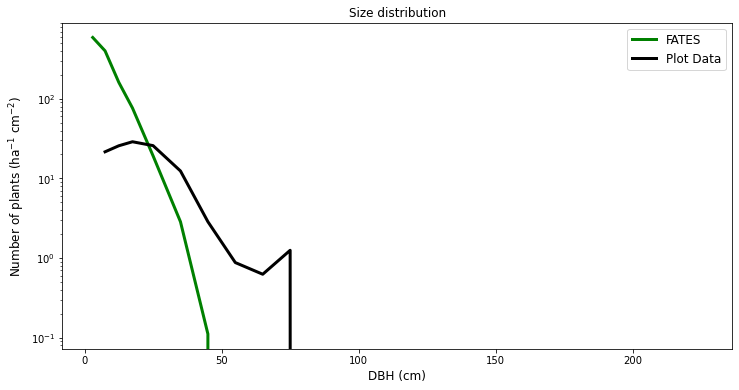

In [14]:
nplant = monthly_to_annual(fates.FATES_NPLANT_SZ)
nplant = np.squeeze(nplant.isel(time=slice(tave_start,tave_stop)).mean(dim='time')) * 10000 # convert to plants per ha (from m-2)

plot_sd = plot_nplant.iloc[1:]/plot_sizebin_widths
fates_sd = nplant[1:]/fates_sizebin_widths


fig2, ((f2ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(12,6))
f2ax0.plot(fates_sizebin_mids, fates_sd, color='green', label = 'FATES', linewidth=3)    
   
f2ax0.set_title(r'Size distribution', fontsize = 12)
f2ax0.set_ylabel(r'Number of plants (ha$^{-1}$ cm$^{-2}$)', fontsize = 12)
f2ax0.set_xlabel(r'DBH (cm)', fontsize = 12)    
       
f2ax0.plot(plot_sizebin_mids, plot_sd, color='black', label = 'Plot Data', linewidth = 3)
f2ax0.set_yscale('log')
f2ax0.legend(prop={'size':12})
;

### Carbon by size 

''

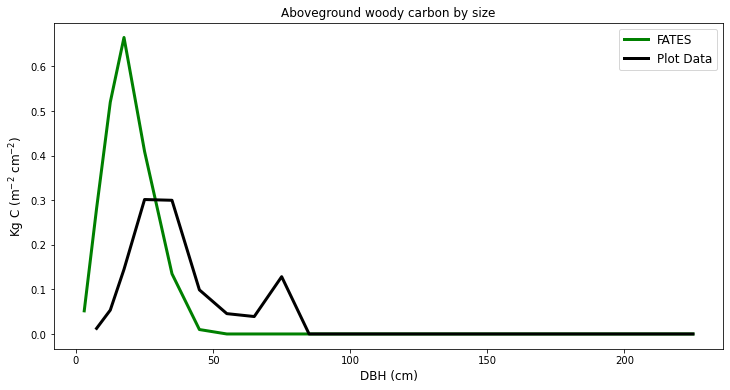

In [15]:
agb_frac = 0.6
WOODC = monthly_to_annual(fates.FATES_WOODC_SZ)
WOODC = np.squeeze(WOODC.isel(time=slice(tave_start,tave_stop)).mean(dim='time')) * agb_frac
fates_agb_sd = WOODC[1:]/fates_sizebin_widths

fig3, ((f3ax0)) = plt.subplots(nrows=1,ncols=1, figsize=(12,6))

f3ax0.plot(fates_sizebin_mids, fates_agb_sd, color='green', label = 'FATES', linewidth=3)    
f3ax0.set_title(r'Aboveground woody carbon by size', fontsize = 12)
f3ax0.set_ylabel(r'Kg C (m$^{-2}$ cm$^{-2}$)', fontsize = 12)
f3ax0.set_xlabel(r'DBH (cm)', fontsize = 12)    
       
plot_cwood_sz = dfss['AGB_size_kgCm.2']
plot_agb_sd = plot_cwood_sz[1:]/plot_sizebin_widths 
f3ax0.plot(plot_sizebin_mids, plot_agb_sd, color='black', label = 'Plot Data', linewidth=3)
f3ax0.legend(prop={'size':12})
;

### Size dependent mortality 

In [16]:
nplant = fa.scpf_to_scls_by_pft(fates.FATES_NPLANT_SZPF, fates)

smort  = fa.scpf_to_scls_by_pft(fates.FATES_MORTALITY_SENESCENCE_SZPF, fates)

smort = np.squeeze(smort / nplant)


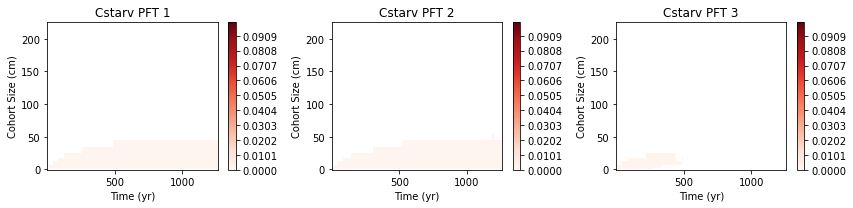

In [17]:
# set up the page
fig3, ((f3ax0,f3ax1,f3ax2)) = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

levels = np.linspace(0,0.1,100)
cmap = plt.get_cmap('Reds')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

im = f3ax0.pcolormesh(time, cohort_size_bins, 
                      smort.isel(fates_levpft=0).transpose(), 
                      cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax0)
f3ax0.set_title(r'Cstarv PFT 1')
f3ax0.set_xlabel('Time (yr)')
f3ax0.set_ylabel('Cohort Size (cm)')
#f3ax0.set_ylim(0,50)

im = f3ax1.pcolormesh(time, cohort_size_bins, 
                      smort.isel(fates_levpft=1).transpose(),
                      cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax1)
f3ax1.set_title(r'Cstarv PFT 2')
f3ax1.set_xlabel('Time (yr)')
f3ax1.set_ylabel('Cohort Size (cm)')
#f3ax1.set_ylim(0,50)

im = f3ax2.pcolormesh(time, cohort_size_bins, 
                      smort.isel(fates_levpft=2).transpose(), 
                      cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax2)
f3ax2.set_title(r'Cstarv PFT 3')
f3ax2.set_xlabel('Time (yr)')
f3ax2.set_ylabel('Cohort Size (cm)')
#f3ax2.set_ylim(0,50)

fig3.tight_layout()

### Growth 

In [18]:
nplant_can = fa.scpf_to_scls_by_pft(fates.FATES_NPLANT_CANOPY_SZPF, fates)
ddbh_can  = fa.scpf_to_scls_by_pft(fates.FATES_DDBH_CANOPY_SZPF, fates) * 100
ddbh_can = np.squeeze(ddbh_can / nplant)

nplant_ust = fa.scpf_to_scls_by_pft(fates.FATES_NPLANT_USTORY_SZPF, fates)
ddbh_ust  = fa.scpf_to_scls_by_pft(fates.FATES_DDBH_USTORY_SZPF, fates) * 100
ddbh_ust = np.squeeze(ddbh_ust / nplant)


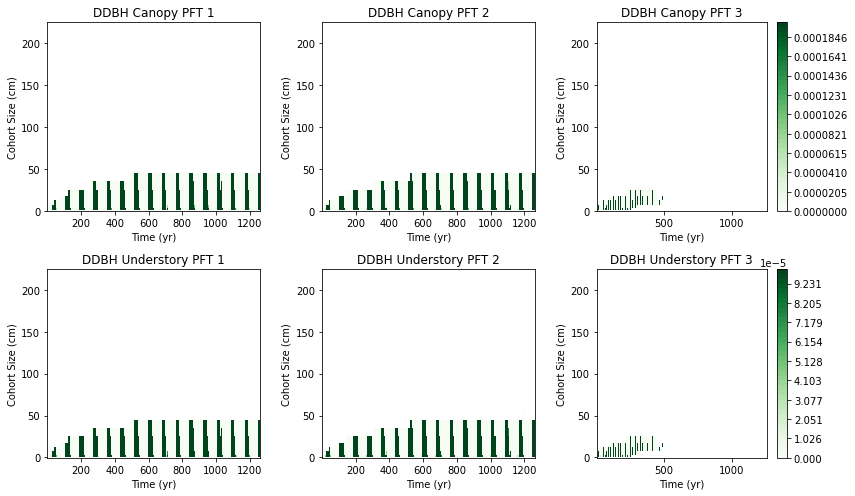

In [19]:
# set up the page
fig3, ((f3ax0,f3ax1,f3ax2),(f3ax3,f3ax4,f3ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(12,7))

levels = np.linspace(0,0.0002,40)
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

im = f3ax0.pcolormesh(time, cohort_size_bins, 
                      ddbh_can.isel(fates_levpft=0).transpose(), 
                      cmap=cmap, norm=norm)
#fig3.colorbar(im, ax=f3ax0)
f3ax0.set_title(r'DDBH Canopy PFT 1')
f3ax0.set_xlabel('Time (yr)')
f3ax0.set_ylabel('Cohort Size (cm)')
#f3ax0.set_ylim(0,50)

im = f3ax1.pcolormesh(time, cohort_size_bins, 
                      ddbh_can.isel(fates_levpft=1).transpose(),
                      cmap=cmap, norm=norm)
#fig3.colorbar(im, ax=f3ax1)
f3ax1.set_title(r'DDBH Canopy PFT 2')
f3ax1.set_xlabel('Time (yr)')
f3ax1.set_ylabel('Cohort Size (cm)')
#f3ax1.set_ylim(0,50)

im = f3ax2.pcolormesh(time, cohort_size_bins, 
                      ddbh_can.isel(fates_levpft=2).transpose(), 
                      cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax2)
f3ax2.set_title(r'DDBH Canopy PFT 3')
f3ax2.set_xlabel('Time (yr)')
f3ax2.set_ylabel('Cohort Size (cm)')
#f3ax2.set_ylim(0,50)

levels = np.linspace(0,0.0001,40)
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

im = f3ax3.pcolormesh(time, cohort_size_bins, 
                      ddbh_can.isel(fates_levpft=0).transpose(), 
                      cmap=cmap, norm=norm)
#fig3.colorbar(im, ax=f3ax3)
f3ax3.set_title(r'DDBH Understory PFT 1')
f3ax3.set_xlabel('Time (yr)')
f3ax3.set_ylabel('Cohort Size (cm)')
#f3ax0.set_ylim(0,50)

im = f3ax4.pcolormesh(time, cohort_size_bins, 
                      ddbh_can.isel(fates_levpft=1).transpose(),
                      cmap=cmap, norm=norm)
#fig3.colorbar(im, ax=f3ax4)
f3ax4.set_title(r'DDBH Understory PFT 2')
f3ax4.set_xlabel('Time (yr)')
f3ax4.set_ylabel('Cohort Size (cm)')
#f3ax1.set_ylim(0,50)

im = f3ax5.pcolormesh(time, cohort_size_bins, 
                      ddbh_can.isel(fates_levpft=2).transpose(), 
                      cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax5)
f3ax5.set_title(r'DDBH Understory PFT 3')
f3ax5.set_xlabel('Time (yr)')
f3ax5.set_ylabel('Cohort Size (cm)')
#f3ax2.set_ylim(0,50)

fig3.tight_layout()